In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.gridspec as gridspec

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_curve, auc

from Bio.Align import substitution_matrices

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')

BLOSUM62 = substitution_matrices.load('BLOSUM62')

SOFTMAX_BLOSUM62 = np.exp(BLOSUM62) / np.exp(BLOSUM62).sum(axis=1)[:, None]

BLOSUM62_DICT = {aa1: {aa2: BLOSUM62[aa1, aa2] for aa2 in AMINO_ACIDS} for aa1 in AMINO_ACIDS}

SOFTMAX_BLOSUM62_DICT = {aa1: {aa2: SOFTMAX_BLOSUM62[aa1, aa2] for aa2 in AMINO_ACIDS} for aa1 in AMINO_ACIDS}


WT_SEQ = 'SLLMWITQC'

df_orig = pd.read_csv('NYES0_test_res_june05.csv')

df_orig

,name,sequence,Top,hamming_distance_from_wt,tcrdock_pae,model,group,position,Resp_GFP,GFP,R1,R2,R3,af3_tcr_pmhc_pae_score,af3_ranking_scores
0,NYESO_p1,RLAQWISQA,T,5.0,5.087110,so3_convnet_base_ensemble,NaN,1,True,21.60,8.819959,8.652531,8.261667,0.994973,0.95
1,NYESO_p2,GLGTWISQV,T,5.0,5.109005,so3_convnet_base_ensemble,NaN,2,True,12.20,3.057442,4.626006,2.113691,1.093910,0.94
2,NYESO_p3,SLLQWVSQV,T,4.0,5.109279,so3_convnet_base_ensemble_fixed_structure,NaN,3,True,73.80,27.669989,26.298373,24.121413,1.374538,0.92
3,NYESO_p4,GLGQWISQA,T,5.0,5.114267,so3_convnet_base_ensemble,NaN,4,False,0.50,0.011150,0.004608,0.003092,1.022366,0.95
4,NYESO_p5,SLLQWISQV,T,3.0,5.134573,so3_convnet_base_ensemble_fixed_structure,NaN,5,True,79.20,26.475036,24.544710,28.995010,1.033960,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NYESO_p92,ALLEWLTTL,F,5.0,6.097432,so3_convnet_noise=0p5_fixed_structure,sampled_between_5p5_and_7_pae,92,False,0.18,0.008657,0.017513,0.003251,11.111741,0.60
92,NYESO_p93,CLMTWLDVV,F,7.0,6.104698,so3_convnet_noise=0p5_fixed_structure,sampled_between_5p5_and_7_pae,93,False,0.22,0.000000,0.000000,0.008956,1.560459,0.88
93,unstim,NaN,F,NaN,NaN,NaN,NaN,94,False,0.20,0.007500,0.008697,0.002912,NaN,NaN
94,NYESO_p95_wt,SLLMWITQC,F,0.0,5.170031,NaN,NaN,95,True,64.90,13.907838,16.127363,15.616423,1.045415,0.95


In [2]:
# ## compute the AF3 PAE score in the same way that Phil does (I think?) in his TCRdock code
# ## also put column with ranking score to see how those correlate, as a baseline
# ## take the best-ranked structure out of the 5 that get returned

# alphafold3_folder = '../../../../peptide_design_analyses/nyeso_alphafold3'

# ## unzip everything
# for filename in os.listdir(alphafold3_folder):
#     if not os.path.exists(f'{alphafold3_folder}/{filename[:-4]}'):
#         if filename.endswith('.zip'):
#             os.makedirs(f'{alphafold3_folder}/{filename[:-4]}')
#             os.system(f'unzip {alphafold3_folder}/{filename} -d alphafold3/{filename[:-4]}')

# def get_ranking_score(json_dict):
#     return json_dict['ranking_score']

# def get_tcr_pmhc_pae_score(json_dict, sequence):

#     ## adapted from Phil's TCRdock code
    
#     cs = ['GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQR',
#           sequence,
#           'QEVTQIPAALSVPEGENLVLNCSFTDSAIYNLQWFRQDPGKGLTSLLLIQSSQREQTSGRLNASLDKSSGRSTLYIAASQPGDSATYLCAVRPTSGGSYIPTFGRGTSLIVHPY',
#           'GVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLIHYSVGAGITDQGEVPNGYNVSRSTTEDFPLRLLSAAPSQTSVYFCASSYVGNTGELFFGEGSRLTVLED']

#     num_chains = len(cs)
#     assert num_chains in [4,5] # mhc class 1 or 2

#     pmhc_chains = range(num_chains-2)
#     tcr_chains = range(num_chains-2, num_chains)

#     inter_pae = 0.
#     pairs = []
#     for i in pmhc_chains:
#         nres_i = len(cs[i])
#         for j in tcr_chains:
#             nres_j = len(cs[j])
#             pae_ij = json_dict['chain_pair_pae_min'][i][j]
#             pae_ji = json_dict['chain_pair_pae_min'][j][i]
#             inter_pae += nres_i * nres_j * (pae_ij + pae_ji)
#             pairs.append((i,j))
#     nres_pmhc = sum(len(cs[x]) for x in pmhc_chains)
#     nres_tcr = sum(len(cs[x]) for x in tcr_chains)
#     inter_pae /= 2*nres_pmhc*nres_tcr

#     return inter_pae


# import json

# af3_tcr_pmhc_pae_scores = []
# af3_ranking_scores = []
# for sequence in df_orig['sequence']:
#     if type(sequence) == str:
#         if os.path.exists(f'{alphafold3_folder}/fold_nyeso_{sequence.lower()}_1/'):
#             temp_ranking_scores = []
#             temp_pae_scores = []
#             for i in range(5):
#                 with open(f'{alphafold3_folder}/fold_nyeso_{sequence.lower()}_1/fold_nyeso_{sequence.lower()}_1_summary_confidences_{i}.json') as f:
#                     summary_confidences = json.load(f)
#                 temp_ranking_scores.append(get_ranking_score(summary_confidences))
#                 temp_pae_scores.append(get_tcr_pmhc_pae_score(summary_confidences, sequence))
            
#             # select best based on ranking score
#             best_i = np.argmin(temp_pae_scores)
#             af3_tcr_pmhc_pae_scores.append(temp_pae_scores[best_i])
#             af3_ranking_scores.append(temp_ranking_scores[best_i])
#         else:
#             af3_tcr_pmhc_pae_scores.append(np.nan)
#             af3_ranking_scores.append(np.nan)
#     else:
#         af3_tcr_pmhc_pae_scores.append(np.nan)
#         af3_ranking_scores.append(np.nan)

# df_orig['af3_tcr_pmhc_pae_score'] = af3_tcr_pmhc_pae_scores
# df_orig['af3_ranking_scores'] = af3_ranking_scores

# df_orig.to_csv('NYES0_test_res_june05.csv', index=False)

In [3]:
df = df_orig.copy()

# cap all the responses at zero
df['R1'][df['R1'] < 0] = 0
df['R2'][df['R2'] < 0] = 0
df['R3'][df['R3'] < 0] = 0

# add epsilon to all responses
eps = 1e-3
df['R1'] = df['R1'] + eps
df['R2'] = df['R2'] + eps
df['R3'] = df['R3'] + eps


score_threshold = np.mean(df[df['name'] == 'unstim'][['R1', 'R2', 'R3']].values[0]) + 3 * np.std(df[df['name'] == 'unstim'][['R1', 'R2', 'R3']].values[0])
score_threshold = max(score_threshold, 0.5)

df['Resp'] = [True if np.mean([r1, r2, r3]) > score_threshold else False for r1, r2, r3 in zip(df['R1'], df['R2'], df['R3'])]

# filter out unstim because it doesn't matter, it's just the control
unstim_values = df[df['name'] == 'unstim'][['R1', 'R2', 'R3']].values[0]
df = df[df['name'] != 'unstim']

WT = 'SLLMWITQC'
WT_V = 'SLLMWITQV'

df['hamming_distance_from_wt_V'] = [sum([1 for i in range(len(seq)) if seq[i] != WT_V[i]]) if type(seq) == str else np.nan for seq in df['sequence']]

df['min_hamming_distance'] = [min(dist_from_wt, dist_from_wt_V) for dist_from_wt, dist_from_wt_V in zip(df['hamming_distance_from_wt'], df['hamming_distance_from_wt_V'])]

resp_wt = df[df['name'] == 'NYESO_p95_wt'][['R1', 'R2', 'R3']].values[0]
resp_wt_V = df[df['name'] == 'NYESO_p96_wt_V'][['R1', 'R2', 'R3']].values[0]

pae_wt = df[df['name'] == 'NYESO_p95_wt']['tcrdock_pae'].values[0]
pae_wt_V = df[df['name'] == 'NYESO_p96_wt_V']['tcrdock_pae'].values[0]

df['R_mean'] = [np.mean([r1, r2, r3]) for r1, r2, r3 in zip(df['R1'], df['R2'], df['R3'])]


## save dataframe to put in paper here
df.to_csv('NYES0_test_res__for_paper.csv', index=False)


# also filter out wt controls because they have no tcrdock_pae score
df = df[df['name'] != 'NYESO_p95_wt']
df = df[df['name'] != 'NYESO_p96_wt_V']

# make blosum score column
df['blosum_full'] = [sum([BLOSUM62[WT_SEQ[i], seq[i]] for i in range(len(seq))]) if type(seq) == str else np.nan for seq in df['sequence']]

# make blosum score column, but only add the blosum scores for residues different from wildtype, and divide by the number of residues
df['blosum_diff'] = [sum([BLOSUM62[WT_SEQ[i], seq[i]] for i in range(len(seq)) if seq[i] != WT_SEQ[i]]) / sum([1 for i in range(len(seq)) if seq[i] != WT_SEQ[i]]) if type(seq) == str else np.nan for seq in df['sequence']]

name_conversion_dict = {'so3_convnet_base_ensemble': 'so3_convnet_base_ensemble__sim_anneal',
                        'so3_convnet_noise=0p5': 'so3_convnet_noise=0p5__sim_anneal',
                        'so3_convnet_base_ensemble_fixed_structure': 'so3_convnet_base_ensemble__fixed_structure',
                        'so3_convnet_noise=0p5_fixed_structure': 'so3_convnet_noise=0p5__fixed_structure'}

df['model'] = [name_conversion_dict[model] for model in df['model']]

df

# print(df['sequence'][np.isnan(df['af3_tcr_pmhc_pae_score'].values)])


/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_84202/1972274707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R1'][df['R1'] < 0] = 0
/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_84202/1972274707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['R2'][df['R2'] < 0] = 0
/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_84202/1972274707.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

,name,sequence,Top,hamming_distance_from_wt,tcrdock_pae,model,group,position,Resp_GFP,GFP,...,R2,R3,af3_tcr_pmhc_pae_score,af3_ranking_scores,Resp,hamming_distance_from_wt_V,min_hamming_distance,R_mean,blosum_full,blosum_diff
0,NYESO_p1,RLAQWISQA,T,5.0,5.087110,so3_convnet_base_ensemble__sim_anneal,NaN,1,True,21.60,...,8.653531,8.262667,0.994973,0.95,True,5,5.0,8.579052,23.0,-0.200000
1,NYESO_p2,GLGTWISQV,T,5.0,5.109005,so3_convnet_base_ensemble__sim_anneal,NaN,2,True,12.20,...,4.627006,2.114691,1.093910,0.94,True,4,4.0,3.266713,19.0,-1.000000
2,NYESO_p3,SLLQWVSQV,T,4.0,5.109279,so3_convnet_base_ensemble__fixed_structure,NaN,3,True,73.80,...,26.299373,24.122413,1.374538,0.92,True,3,3.0,26.030925,31.0,0.750000
3,NYESO_p4,GLGQWISQA,T,5.0,5.114267,so3_convnet_base_ensemble__sim_anneal,NaN,4,False,0.50,...,0.005608,0.004092,1.022366,0.95,False,5,5.0,0.007283,21.0,-0.600000
4,NYESO_p5,SLLQWISQV,T,3.0,5.134573,so3_convnet_base_ensemble__fixed_structure,NaN,5,True,79.20,...,24.545710,28.996010,1.033960,0.95,True,2,2.0,26.672585,32.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,NYESO_p89,SLLEWQCIL,F,5.0,6.012370,so3_convnet_noise=0p5__fixed_structure,sampled_between_5p5_and_7_pae,89,False,0.22,...,0.025713,0.001000,15.305896,0.52,False,5,5.0,0.012482,13.0,-2.000000
89,NYESO_p90,ALLEWIDIV,F,5.0,6.034572,so3_convnet_noise=0p5__fixed_structure,sampled_between_5p5_and_7_pae,90,False,0.18,...,0.010953,0.006106,8.092380,0.57,False,4,4.0,0.007250,17.0,-1.200000
90,NYESO_p91,ALLEWVTEV,F,5.0,6.045005,so3_convnet_base_ensemble__fixed_structure,sampled_between_5p5_and_7_pae,91,False,0.23,...,0.007642,0.005229,17.366839,0.51,False,4,4.0,0.005541,27.0,0.600000
91,NYESO_p92,ALLEWLTTL,F,5.0,6.097432,so3_convnet_noise=0p5__fixed_structure,sampled_between_5p5_and_7_pae,92,False,0.18,...,0.018513,0.004251,11.111741,0.60,False,5,5.0,0.010807,23.0,-0.200000


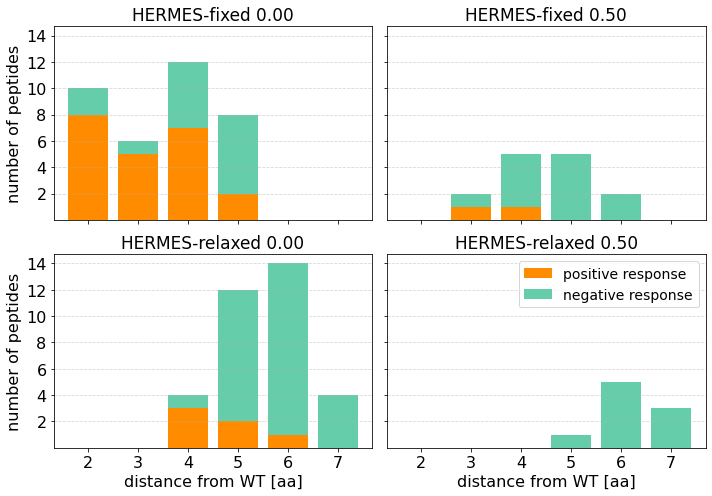

In [4]:
# make a barplot of success over distance from wildtype for the 4 model classes
models_of_interest = ['so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal']

model_name_to_pretty_name = {
    'so3_convnet_base_ensemble__fixed_structure': 'HERMES-fixed 0.00',
    'so3_convnet_noise=0p5__fixed_structure': 'HERMES-fixed 0.50',
    'so3_convnet_base_ensemble__sim_anneal': 'HERMES-relaxed 0.00',
    'so3_convnet_noise=0p5__sim_anneal': 'HERMES-relaxed 0.50'
}

resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}
model_to_marker = {'hpvg_wt': 'X', 'hpvg_q5_wt': 'X', 'so3_convnet_base_ensemble__fixed_structure': 's', 'so3_convnet_noise=0p5__fixed_structure': 'd', 'so3_convnet_base_ensemble__sim_anneal': '<', 'so3_convnet_noise=0p5__sim_anneal': '>'}
models = list(model_to_marker.keys())

fontsize = 16

ncols = 2
nrows = 2
colsize = 5
rowsize = 3.5
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

for i, (ax, model) in enumerate(zip(axs.flatten(), models_of_interest)):
    mask = df['model'] == model
    curr_df = df[mask]
    distances = curr_df['min_hamming_distance'].values
    responses = curr_df['Resp'].values

    # barplot with distance on x axis, and on y axis positive resp in one color, negative resp in another color
    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
    
    distances = list(distance_to_resp.keys())
    pos_responses = [distance_to_resp[distance][True] for distance in distances]
    neg_responses = [distance_to_resp[distance][False] for distance in distances]

    row = i // ncols
    col = i % ncols

    ax.bar(distances, pos_responses, color=resp_to_color[True])
    ax.bar(distances, neg_responses, bottom=pos_responses, color=resp_to_color[False])
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    ax.set_title(model_name_to_pretty_name[model], fontsize=fontsize+1)
    ax.set_xticks([2, 3, 4, 5, 6, 7])
    ax.set_yticks([2, 4, 6, 8, 10, 12, 14])
    ax.tick_params(axis='both', labelsize=fontsize)
    if row == nrows-1: ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
    if col == 0: ax.set_ylabel('number of peptides', fontsize=fontsize)

    if row == nrows-1 and col == ncols-1:
        ax.legend(['positive response', 'negative response'], fontsize=fontsize-2)

plt.tight_layout()
plt.savefig('__pretty_hits_vs_hamming_distance_from_wt_split_by_model.png')
plt.savefig('__pretty_hits_vs_hamming_distance_from_wt_split_by_model.pdf')
plt.show()

('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure')
4
4
('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal')
4
4


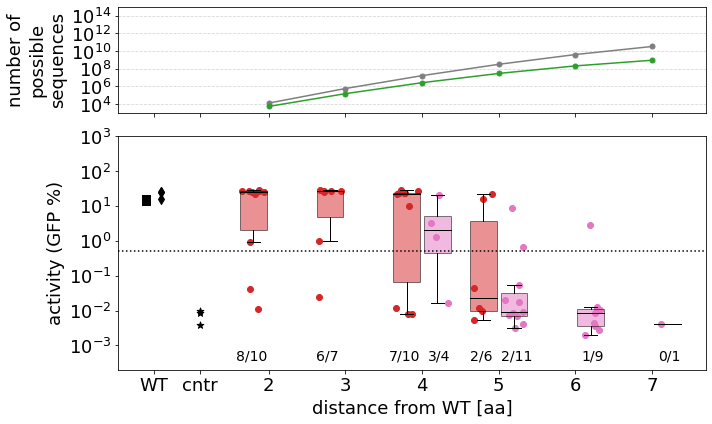

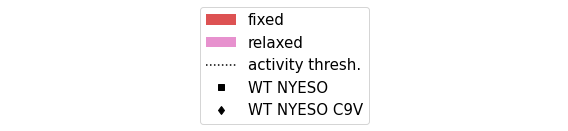

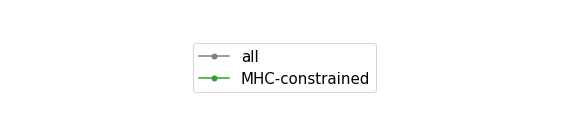

In [30]:
fontsize = 18

# make a barplot of success over distance from wildtype for the 4 model classes
model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure'), ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal')]
model_group_names = ['fixed', 'annealing']
colors = ['tab:red', 'tab:pink']

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2.2])

# Bottom subplot
ax = fig.add_subplot(gs[1])

df_here = df.loc[df['tcrdock_pae'] < 5.5]

all_distances = sorted(np.unique(df_here['min_hamming_distance'].values))

for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
    print(model_group)
    mask = df_here['model'].isin(model_group)
    curr_df = df_here[mask]
    distances = curr_df['min_hamming_distance'].values
    responses = curr_df['Resp'].values

    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
        
    # distance_to_exp_score = {}
    distance_to_mean_exp_score = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_mean_exp_score[distance] = curr_df[dist_mask]['R_mean'].values
        # distance_to_exp_score[distance] = np.vstack([curr_df[dist_mask]['R1'],
        #                                                           curr_df[dist_mask]['R2'],
        #                                                           curr_df[dist_mask]['R3']])
        # distance_to_mean_exp_score[distance] = np.mean(distance_to_exp_score[distance], axis=0)
    
    distances = list(distance_to_mean_exp_score.keys())
    # scores = [distance_to_mean_exp_score[distance] for distance in distances]
    log_mean_scores = [np.log10(distance_to_mean_exp_score[distance]) for distance in distances]

    positions = [distance - 0.2 + i*0.4 for distance in distances]

    print(len(log_mean_scores))
    print(len(positions))
    ax.boxplot(log_mean_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

    k = 0
    for position, scores_in_distance in zip(positions, log_mean_scores):
        if len(scores_in_distance.shape) == 2:
            scores_in_distance = scores_in_distance.T
        for item in scores_in_distance:
            noise = np.random.uniform(-0.15, 0.15)
            len_item = len(item) if isinstance(item, np.ndarray) else 1
            if k == 0:
                ax.scatter([position+noise], item, color=color, label=model_group_name)
                # ax.errorbar([position+noise], np.log10(np.mean(item)), yerr=np.std(item)/np.sqrt(len_item), color=color, capsize=5)
            else:
                ax.scatter([position+noise], item, color=color)
                # ax.errorbar([position+noise], np.log10(np.mean(item)), yerr=np.std(item)/np.sqrt(len_item), color=color, capsize=5)
            k += 1

    # put number of examples under each boxplot
    ax.set_ylim(-3.7, 2)
    for position, distance, scores_in_distance in zip(positions, distances, log_mean_scores):
        offset = 0.03 if i == 1 else -0.03
        ax.text(position+offset, -3.5, f'{int(distance_to_resp[distance][True])}/{len(scores_in_distance)}', ha='center', va='bottom', fontsize=fontsize-4)


min_distance = min(all_distances)
wt_xtick = min_distance - 1.5
control_xtick = wt_xtick + 0.6

ax.scatter([wt_xtick-0.1]*len(resp_wt), np.log10(resp_wt), color='black', marker='s', s=50)
ax.scatter([wt_xtick+0.1]*len(resp_wt_V), np.log10(resp_wt_V), color='black', marker='d', s=50)
ax.scatter([control_xtick]*len(unstim_values), np.log10(unstim_values), color='black', marker='*', s=50)

ax.axhline(np.log10(score_threshold), color='black', linestyle=':', label='activity thresh.')

xticks = [wt_xtick, control_xtick] + list(all_distances)
xticklabels = ['WT', 'cntr'] + [str(int(distance)) for distance in all_distances]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# print(ax.get_yticks())
# print(ax.get_yticklabels()[0])

yticks = [-3, -2, -1, 0, 1, 2, 3]
ax.set_yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks])

# print(ax.get_yticklabels()[0])

ax.tick_params(axis='both', labelsize=fontsize)


ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
ax.set_ylabel('activity (GFP %)', fontsize=fontsize)


import json
with open('all_possibilities_class_I_A0201_9_nyeso_k_to_num_sequences.json', 'r') as f:
    k_to_num_sequences_all = json.load(f)
with open('mhc_constrainted_class_I_A0201_9_nyeso_k_to_num_sequences.json', 'r') as f:
    k_to_num_sequences_mhc = json.load(f)

all_values = [k_to_num_sequences_all[str(int(k))] for k in all_distances]
mhc_values = [k_to_num_sequences_mhc[str(int(k))] for k in all_distances]

# put mhc_values on the plot, show ticks and label on right y-axis, in log-scale
# Top subplot
ax2 = fig.add_subplot(gs[0], sharex=ax)
ax2.plot(all_distances, np.log10(all_values), color='tab:grey', linestyle='-', marker='o', markersize=5, label='all')
ax2.plot(all_distances, np.log10(mhc_values), color='tab:green', linestyle='-', marker='o', markersize=5, label='MHC-constrained')
# ax2.set_yticks(np.log10(mhc_values))
# ax2.set_yticklabels(mhc_values)
# ax2.set_ylim(ax.get_ylim())

ax2.tick_params(labelbottom=False)

ax2.set_ylim([3, 15])
yticks = [4, 6, 8, 10, 12, 14]
ax2.set_yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks])

ax2.tick_params(axis='y', labelsize=fontsize)
ax2.set_ylabel('number of\npossible\nsequences', fontsize=fontsize)

ax2.grid(axis='y', linestyle='--', alpha=0.5)


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(facecolor='tab:red', alpha=0.8, label='fixed'),
                    Patch(facecolor='tab:pink', alpha=0.8, label='relaxed'),
                    Line2D([0], [0], color='black', linestyle=':', label='activity thresh.'),
                    Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT NYESO'),
                    Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT NYESO C9V')]

legend_handles_2 = ax2.get_legend_handles_labels()[0]

# ax.legend(handles=legend_handles, fontsize=fontsize-3, bbox_to_anchor=(1.35, 0.80))
# ax2.legend(handles=legend_handles_2, fontsize=fontsize-3, bbox_to_anchor=(1.35, 0.70))

plt.tight_layout()
plt.savefig('__pretty_nyeso_mean_exp_scores_vs_hamming_distance_from_wt.png')
plt.savefig('__pretty_nyeso_mean_exp_scores_vs_hamming_distance_from_wt.pdf')
plt.show()


# put legends in separate figures
fig_leg_1 = plt.figure(figsize=(8, 2))
ax_leg_1 = fig_leg_1.add_subplot(111)
ax_leg_1.legend(handles=legend_handles, fontsize=fontsize-3, loc='center')
ax_leg_1.axis('off')
plt.tight_layout()
plt.savefig('__pretty_nyeso_mean_exp_scores_vs_hamming_distance_from_wt_legend_bottom.png')
plt.savefig('__pretty_nyeso_mean_exp_scores_vs_hamming_distance_from_wt_legend_bottom.pdf')
plt.show()

fig_leg_2 = plt.figure(figsize=(8, 2))
ax_leg_2 = fig_leg_2.add_subplot(111)
ax_leg_2.legend(handles=legend_handles_2, fontsize=fontsize-3, loc='center')
ax_leg_2.axis('off')
plt.tight_layout()
plt.savefig('__pretty_nyeso_mean_exp_scores_vs_hamming_distance_from_wt_legend_top.png')
plt.savefig('__pretty_nyeso_mean_exp_scores_vs_hamming_distance_from_wt_legend_top.pdf')
plt.show()


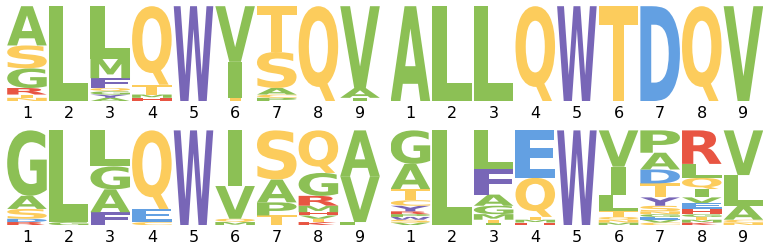

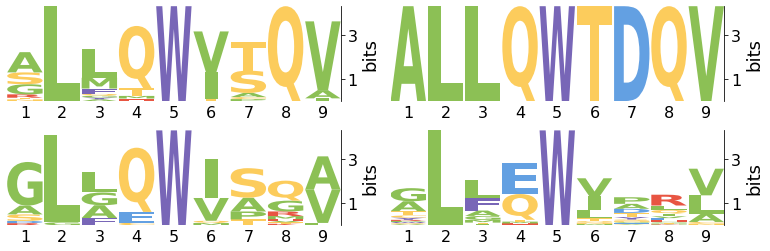

In [33]:
# 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# write the number of sequences in each logoplot

import sys
sys.path.append('../../../src/')
from global_constants import LOGOMAKER_COLORS

def entropy(p):
    return -np.nansum(p * np.log2(p + 1e-10))

# true and tcrdock pae below 5.5
df_true_below = df[(df['tcrdock_pae'] < 5.5) & (df['Resp'] == True)]
df_true_above = df[(df['tcrdock_pae'] >= 5.5) & (df['Resp'] == True)]
df_false_below = df[(df['tcrdock_pae'] < 5.5) & (df['Resp'] == False)]
df_false_above = df[(df['tcrdock_pae'] >= 5.5) & (df['Resp'] == False)]

# make 4 logoplots in a 2x2 subplots grid

def make_logoplot(use_entropy=False):

    fig, axs = plt.subplots(2, 2, figsize=(2*5.4, 2*1.8))

    for i, (df_, title) in enumerate(zip([df_true_below, df_true_above, df_false_below, df_false_above],
                                        ['true positives', 'false negatives', 'false positives', 'true negatives'])):
                                        #  ['Responding and Good tcrdock pae (< 5.5)', 'Responding and Bad tcrdock pae (>= 5.5)', 'Non-Responding and Good tcrdock pae (< 5.5)', 'Non-Responding and Bad tcrdock pae (>= 5.5)'])):
        ax = axs[i // 2, i % 2]
        # get sequences, make pwm
        seqs = df_['sequence']
        pwm = np.zeros((len(WT_SEQ), len(AMINO_ACIDS)))
        for seq in seqs:
            for i, aa in enumerate(seq):
                pwm[i, AMINO_ACIDS.index(aa)] += 1
        pwm = pwm / pwm.sum(axis=1)[:, None]
        pwm[np.isnan(pwm)] = 0

        if use_entropy:
            ics = []
            for row in pwm:
                ics.append(np.log2(20) - entropy(row))
            ics = np.array(ics)
            pwm = pwm * ics[:, np.newaxis]

        # plot pwm as logoplot
        df_pwm = pd.DataFrame(pwm, columns=AMINO_ACIDS)
        logomaker.Logo(df_pwm, ax=ax, color_scheme=LOGOMAKER_COLORS)

        if use_entropy:
            ax.set_ylim([0, np.log2(20)])
        else:
            ax.set_ylim([0, 1])

        # ax.set_title(title + f'\n{len(seqs)} peptides', fontsize=16)

        ax.set_xticks(np.arange(len(WT_SEQ)))
        ax.set_xticklabels(np.arange(len(WT_SEQ))+1)

        ax.tick_params(axis='x', labelsize=16)

        # Remove x-tick marks but keep the labels
        ax.tick_params(axis='x', which='both', length=0)

        # ax.set_xticks([])

        # Remove all the spines
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        if not use_entropy:
            ax.spines['right'].set_visible(False)
            ax.set_yticks([])
        else:
            ax.yaxis.set_ticks_position('right')  # Set ticks on the right
            ax.yaxis.set_label_position('right')  # Set the label on the right
            ax.set_ylabel('bits', fontsize=fontsize)
            ax.set_yticks([1, 3])
            ax.tick_params(axis='y', labelsize=fontsize-2)
    
    if use_entropy:
        use_entropy_str = '_norm_entropy'
    else:
        use_entropy_str = ''

    plt.tight_layout()
    plt.savefig(f'__pretty_logoplots{use_entropy_str}_tcrdock_pae.png')
    plt.savefig(f'__pretty_logoplots{use_entropy_str}_tcrdock_pae.pdf')
    plt.show()

make_logoplot(use_entropy=False)
make_logoplot(use_entropy=True)


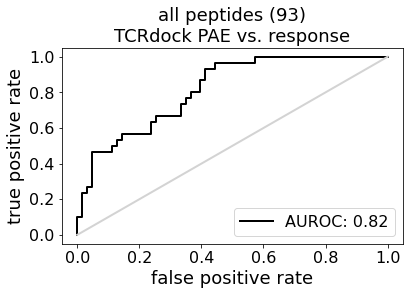

58


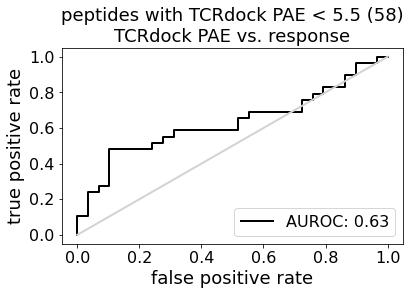

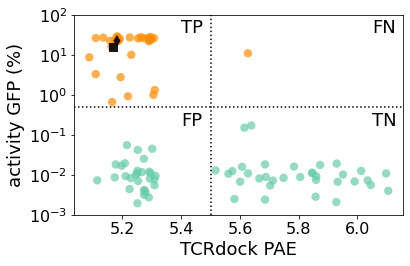

In [67]:
fontsize = 18

# roc curve plot and auroc for tcrdock_pae
fpr, tpr, _ = roc_curve(df['Resp'], -df['tcrdock_pae'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.8, 4.2))
plt.title(f'all peptides ({len(df)})\nTCRdock PAE vs. response', fontsize=fontsize)
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('false positive rate', fontsize=fontsize)
plt.ylabel('true positive rate', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)
# plt.title('TCRdock TCR-pMHC PAE', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize-2)
plt.tight_layout()
plt.savefig(f'__pretty_nyeso_roc_all_peptides.png')
plt.savefig(f'__pretty_nyeso_roc_all_peptides.pdf')
plt.show()


# roc curve plot and auroc for tcrdock_pae
print(len(df.loc[df['tcrdock_pae'] < 5.5]))
fpr, tpr, _ = roc_curve(df.loc[df['tcrdock_pae'] < 5.5]['Resp'], -df.loc[df['tcrdock_pae'] < 5.5]['tcrdock_pae'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.8, 4.2))
plt.title(f'peptides with TCRdock PAE < 5.5 ({len(df.loc[df["tcrdock_pae"] < 5.5])})\nTCRdock PAE vs. response', fontsize=fontsize)
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('false positive rate', fontsize=fontsize)
plt.ylabel('true positive rate', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)
# plt.title('TCRdock TCR-pMHC PAE', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize-2)
plt.tight_layout()
plt.savefig(f'__pretty_nyeso_roc_positive_peptides.png')
plt.savefig(f'__pretty_nyeso_roc_positive_peptides.pdf')
plt.show()


colors = {True: 'darkorange', False: 'mediumaquamarine'}

predictor = 'tcrdock_pae'
measurement = 'R_mean'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(df[df['Resp'] == response][predictor], np.log10(df[df['Resp'] == response][measurement]), c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(pae_wt, np.log10(np.mean(resp_wt)), marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(pae_wt_V, np.log10(np.mean(resp_wt_V)), marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

plt.axvline(5.5, color='black', linestyle=':')
plt.axhline(np.log10(score_threshold), color='black', linestyle=':')

plt.xlabel('TCRdock PAE', fontsize=fontsize)
plt.ylabel('activity GFP (%)', fontsize=fontsize)

yticks = [-3, -2, -1, 0, 1, 2]
plt.yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks], fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)

plt.text(5.4, np.log10(35), 'TP', fontsize=fontsize)
plt.text(5.4, np.log10(0.17), 'FP', fontsize=fontsize)
plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_nyeso_scatterplot.png')
plt.savefig(f'__pretty_nyeso_scatterplot.pdf')
plt.show()


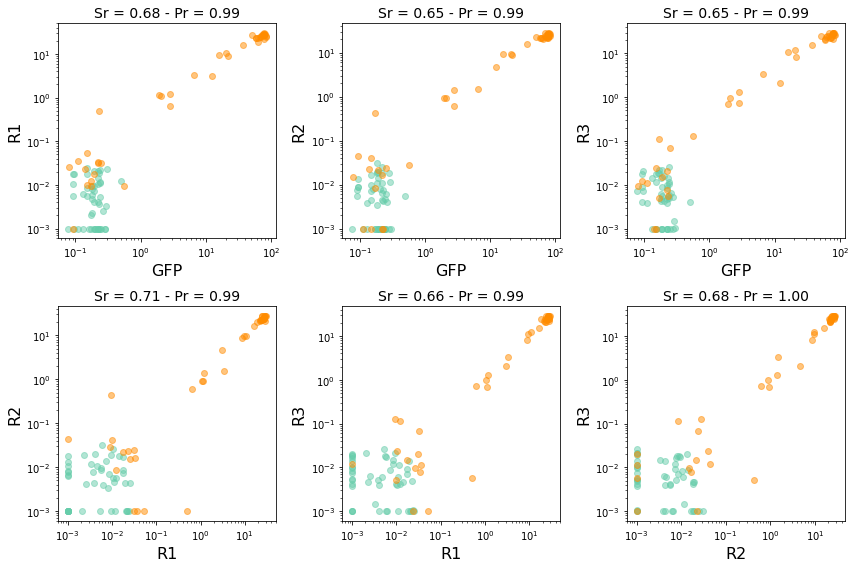

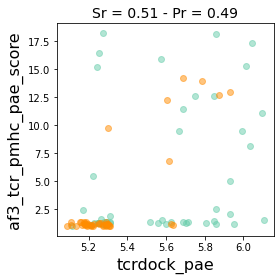

In [252]:
## plot replicates against each other

ncols = 3
nrows = 2
colsize = 4
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows)

colors = {True: 'darkorange', False: 'mediumaquamarine'}

replicates_columns = ['R1', 'R2', 'R3']

# first row is GFP against R1, R2 and R3

for col, rep in enumerate(replicates_columns):
    ax = axs[0, col]
    for response in [False, True]:
        ax.scatter(df[df['Resp'] == response]['GFP'], df[df['Resp'] == response][rep], c=colors[response], alpha=0.5)
    ax.set_title('Sr = %.2f - Pr = %.2f' % (spearmanr(df['GFP'], df[rep])[0], pearsonr(df['GFP'], df[rep])[0]), fontsize=14)
    ax.set_xlabel('GFP', fontsize=16)
    ax.set_ylabel(rep, fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')

# second row is replicates against each other
for col, (rep1, rep2) in enumerate([(rep1, rep2) for i, rep1 in enumerate(replicates_columns) for rep2 in replicates_columns[i+1:] if rep1 != rep2]):
    ax = axs[1, col]
    for response in [False, True]:
        ax.scatter(df[df['Resp'] == response][rep1], df[df['Resp'] == response][rep2], c=colors[response], alpha=0.5)
    ax.set_title('Sr = %.2f - Pr = %.2f' % (spearmanr(df[rep1], df[rep2])[0], pearsonr(df[rep1], df[rep2])[0]), fontsize=14)
    ax.set_xlabel(rep1, fontsize=16)
    ax.set_ylabel(rep2, fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

## plot tcrdock_pae against af3_tcr_pmhc_pae_score

plt.figure(figsize=(4, 4))
for response in [False, True]:
    mask = np.logical_and(df['Resp'] == response, ~np.isnan(df['af3_tcr_pmhc_pae_score']))
    plt.scatter(df[mask]['tcrdock_pae'], df[mask]['af3_tcr_pmhc_pae_score'], c=colors[response], alpha=0.5)
plt.title('Sr = %.2f - Pr = %.2f' % (spearmanr(df['tcrdock_pae'][~np.isnan(df['af3_tcr_pmhc_pae_score'])], df['af3_tcr_pmhc_pae_score'][~np.isnan(df['af3_tcr_pmhc_pae_score'])])[0], pearsonr(df['tcrdock_pae'][~np.isnan(df['af3_tcr_pmhc_pae_score'])], df['af3_tcr_pmhc_pae_score'][~np.isnan(df['af3_tcr_pmhc_pae_score'])])[0]), fontsize=14)
plt.xlabel('tcrdock_pae', fontsize=16)
plt.ylabel('af3_tcr_pmhc_pae_score', fontsize=16)
plt.tight_layout()
plt.show()


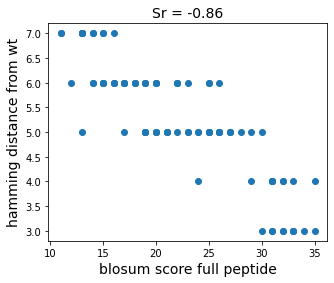

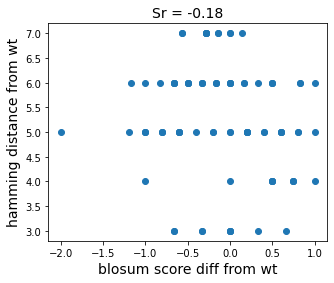

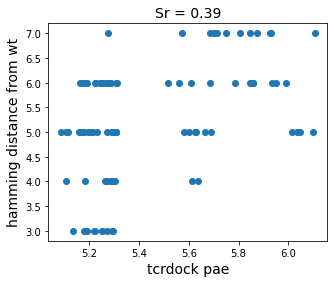

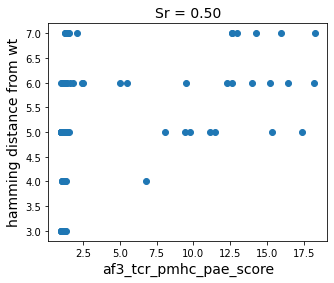

In [125]:
plt.figure(figsize=(5, 4))
plt.scatter(df['blosum_full'], df['hamming_distance_from_wt'])
plt.xlabel('blosum score full peptide', fontsize=14)
plt.ylabel('hamming distance from wt', fontsize=14)
plt.title(f'Sr = {spearmanr(df["blosum_full"], df["hamming_distance_from_wt"])[0]:.2f}', fontsize=14)
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(df['blosum_diff'], df['hamming_distance_from_wt'])
plt.xlabel('blosum score diff from wt', fontsize=14)
plt.ylabel('hamming distance from wt', fontsize=14)
plt.title(f'Sr = {spearmanr(df["blosum_diff"], df["hamming_distance_from_wt"])[0]:.2f}', fontsize=14)
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(df['tcrdock_pae'], df['hamming_distance_from_wt'])
plt.xlabel('tcrdock pae', fontsize=14)
plt.ylabel('hamming distance from wt', fontsize=14)
plt.title(f'Sr = {spearmanr(df["tcrdock_pae"], df["hamming_distance_from_wt"])[0]:.2f}', fontsize=14)
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(df['af3_tcr_pmhc_pae_score'], df['hamming_distance_from_wt'])
plt.xlabel('af3_tcr_pmhc_pae_score', fontsize=14)
plt.ylabel('hamming distance from wt', fontsize=14)
plt.title(f'Sr = {spearmanr(df["af3_tcr_pmhc_pae_score"], df["hamming_distance_from_wt"])[0]:.2f}', fontsize=14)
plt.show()


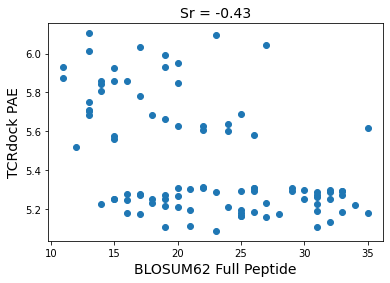

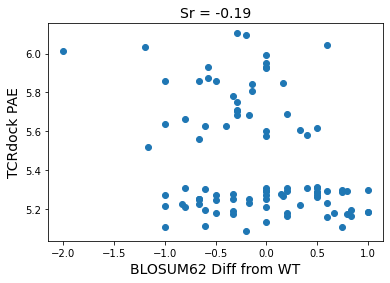

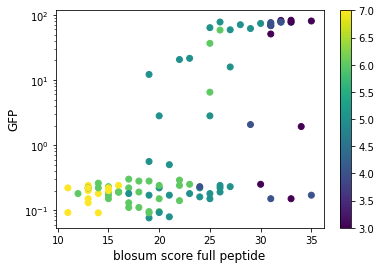

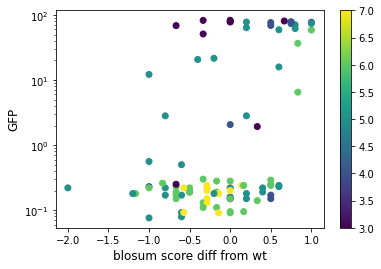

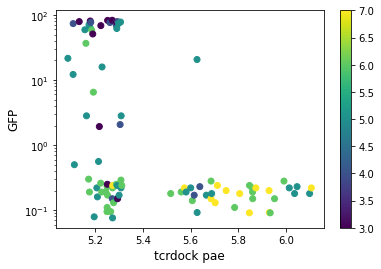

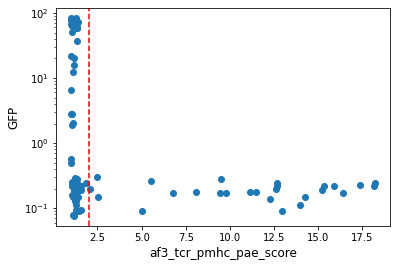

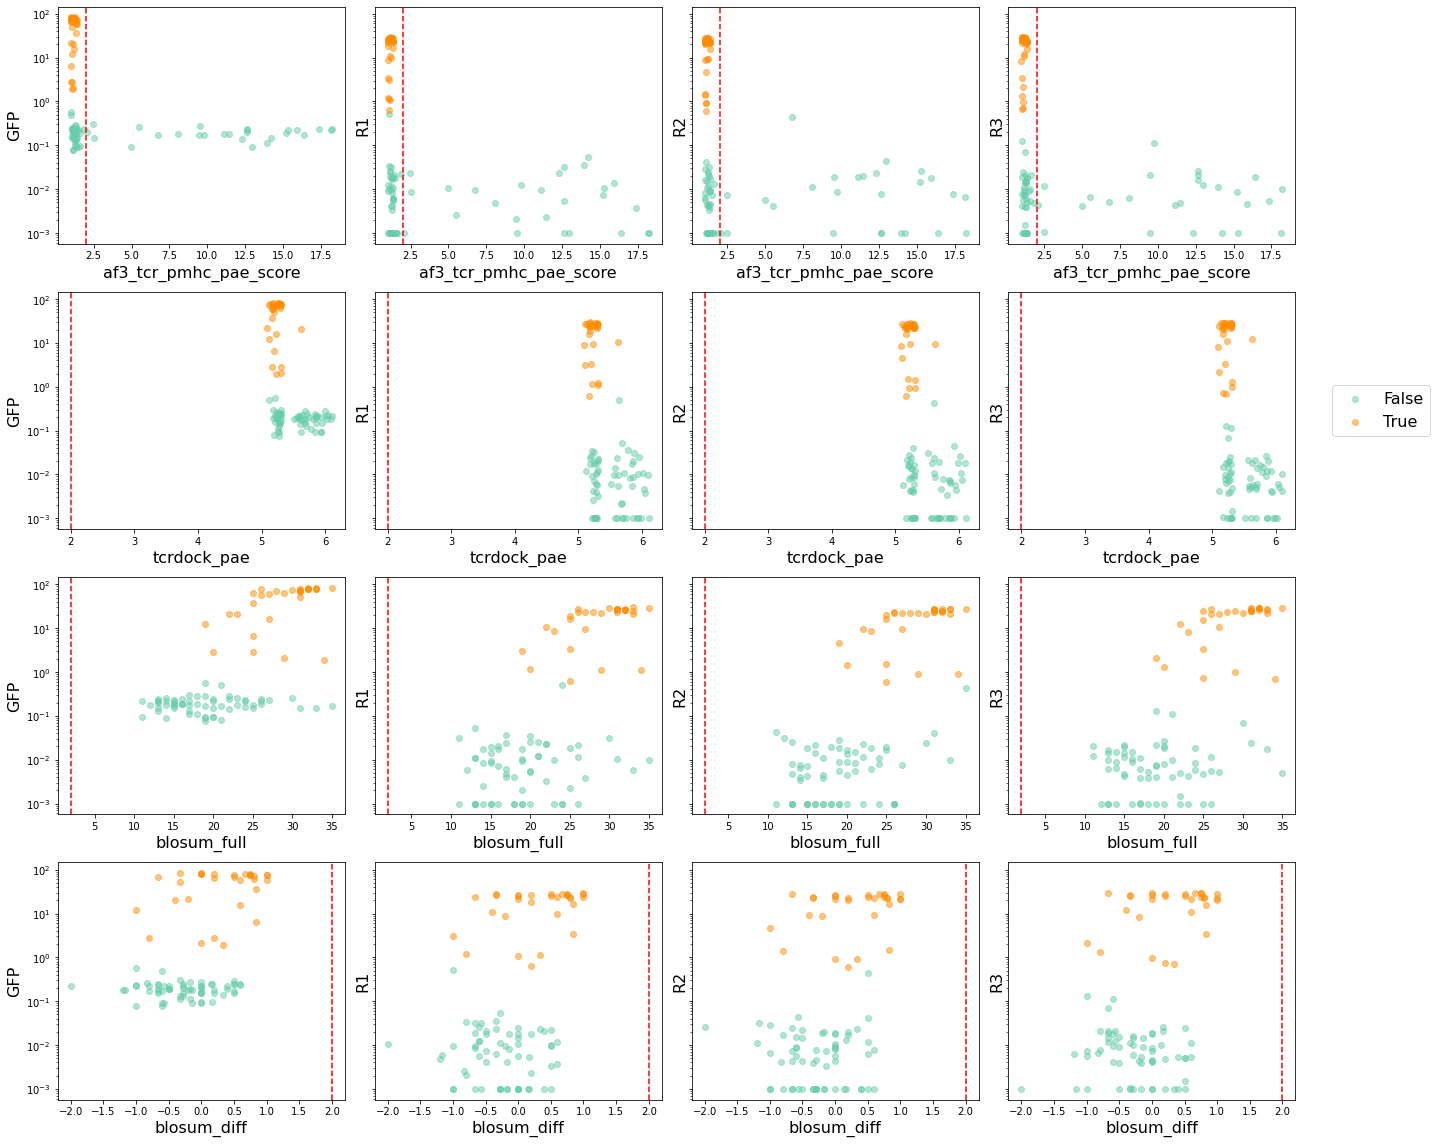

In [126]:
# plot blosum score vs tcrdock_pae, print spearman correlation on plot, color by hamming_distance_from_wt

plt.figure(figsize=(6, 4))
plt.scatter(df['blosum_full'], df['tcrdock_pae'])
plt.xlabel('BLOSUM62 Full Peptide', fontsize=14)
plt.ylabel('TCRdock PAE', fontsize=14)
plt.title(f'Sr = {spearmanr(df["blosum_full"], df["tcrdock_pae"])[0]:.2f}', fontsize=14)
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df['blosum_diff'], df['tcrdock_pae'])
plt.xlabel('BLOSUM62 Diff from WT', fontsize=14)
plt.ylabel('TCRdock PAE', fontsize=14)
plt.title(f'Sr = {spearmanr(df["blosum_diff"], df["tcrdock_pae"])[0]:.2f}', fontsize=14)
plt.show()

# plot blosum_full vs GFP, color points by hamming_distance_from_wt
plt.figure(figsize=(6, 4))
plt.scatter(df['blosum_full'], df['GFP'], c=df['hamming_distance_from_wt'])
plt.yscale('log')
plt.xlabel('blosum score full peptide', fontsize=12)
plt.ylabel('GFP', fontsize=12)
plt.colorbar()
plt.show()

# plot blosum_diff vs GFP, color points by hamming_distance_from_wt
plt.figure(figsize=(6, 4))
plt.scatter(df['blosum_diff'], df['GFP'], c=df['hamming_distance_from_wt'])
plt.yscale('log')
plt.xlabel('blosum score diff from wt', fontsize=12)
plt.ylabel('GFP', fontsize=12)
plt.colorbar()
plt.show()

# plot tcrdock_pae vs GFP, color points by hamming_distance_from_wt
plt.figure(figsize=(6, 4))
plt.scatter(df['tcrdock_pae'], df['GFP'], c=df['hamming_distance_from_wt'])
plt.yscale('log')
plt.xlabel('tcrdock pae', fontsize=12)
plt.ylabel('GFP', fontsize=12)
plt.colorbar()
plt.show()

# plot af3_tcr_pmhc_pae_score vs GFP
plt.figure(figsize=(6, 4))
plt.scatter(df['af3_tcr_pmhc_pae_score'], df['GFP'])
plt.axvline(2.0, color='red', linestyle='--')
plt.yscale('log')
plt.xlabel('af3_tcr_pmhc_pae_score', fontsize=12)
plt.ylabel('GFP', fontsize=12)
plt.show()


colors = {True: 'darkorange', False: 'mediumaquamarine'}
ncols = 4
nrows = 4
colsize = 5
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharey=True)

for row, predictor in enumerate(['af3_tcr_pmhc_pae_score', 'tcrdock_pae', 'blosum_full', 'blosum_diff']):
    for col, measurement in enumerate(['GFP', 'R1', 'R2', 'R3']):
        ax = axs[row, col]
        for response in [False, True]:
            ax.scatter(df[df['Resp'] == response][predictor], df[df['Resp'] == response][measurement], c=colors[response], alpha=0.5, label=response)
        ax.axvline(2.0, color='red', linestyle='--')
        ax.set_yscale('log')
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(measurement, fontsize=16)
        # ax.legend(fontsize=14)

# make legend with right colors, put it on the right
axs[1, 3].legend(['False', 'True'], fontsize=16, loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.show()


<Figure size 432x288 with 0 Axes>

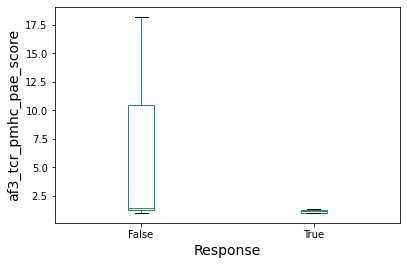

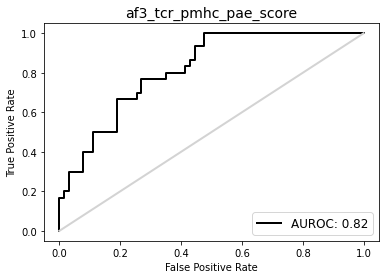

<Figure size 432x288 with 0 Axes>

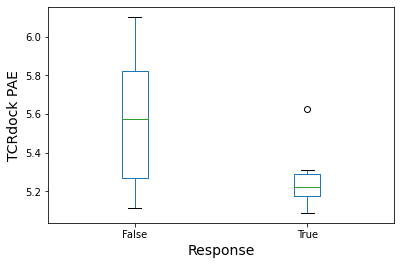

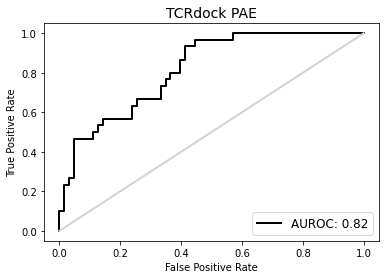

<Figure size 432x288 with 0 Axes>

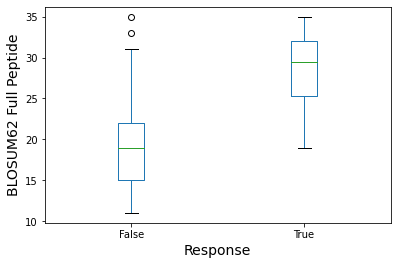

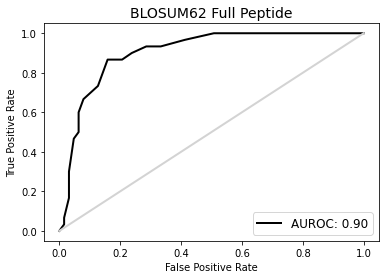

<Figure size 432x288 with 0 Axes>

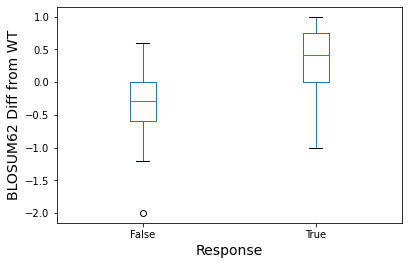

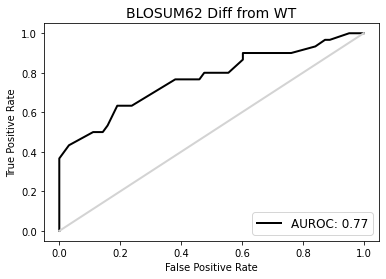

In [127]:
## replicate Asya's plots, to make sure stuff is right

# boxplot with af3_ranking_scores on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='af3_tcr_pmhc_pae_score', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('af3_tcr_pmhc_pae_score', fontsize=14)
plt.show()

# roc curve plot and auroc for tcrdock_pae
mask = ~df['af3_tcr_pmhc_pae_score'].isna()
fpr, tpr, _ = roc_curve(df['Resp'][mask], -df['af3_tcr_pmhc_pae_score'][mask])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('af3_tcr_pmhc_pae_score', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


# boxplot with tcrdock_pae on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='tcrdock_pae', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('TCRdock PAE', fontsize=14)
plt.show()

# roc curve plot and auroc for tcrdock_pae
fpr, tpr, _ = roc_curve(df['Resp'], -df['tcrdock_pae'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TCRdock PAE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


# boxplot with blosum_full on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='blosum_full', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('BLOSUM62 Full Peptide', fontsize=14)
plt.show()

# roc curve plot and auroc for blosum_full
fpr, tpr, _ = roc_curve(df['Resp'], df['blosum_full'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BLOSUM62 Full Peptide', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


# boxplot with blosum_diff on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='blosum_diff', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('BLOSUM62 Diff from WT', fontsize=14)
plt.show()

# roc curve plot and auroc for blosum_diff
fpr, tpr, _ = roc_curve(df['Resp'], df['blosum_diff'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BLOSUM62 Diff from WT', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()




<Figure size 432x288 with 0 Axes>

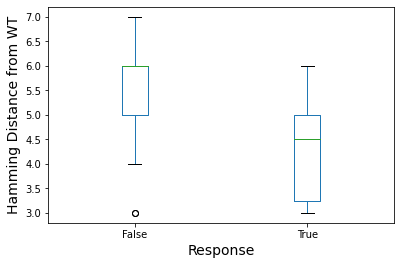

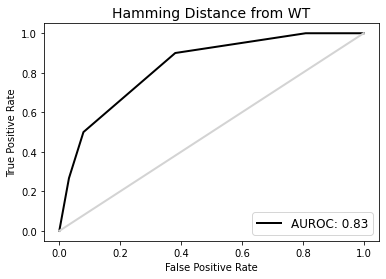

In [128]:
# boxplot
plt.figure(figsize=(6, 4))
df.boxplot(column='hamming_distance_from_wt', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('Hamming Distance from WT', fontsize=14)
plt.show()

# roc curve plot and auroc for combined score
fpr, tpr, _ = roc_curve(df['Resp'], -df['hamming_distance_from_wt'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hamming Distance from WT', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

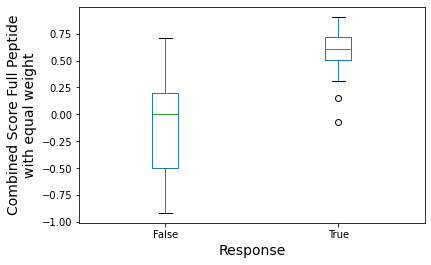

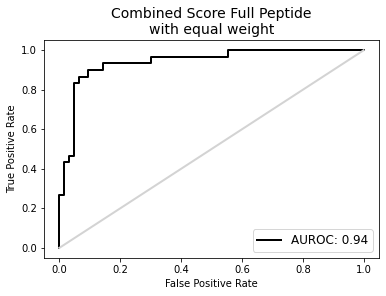

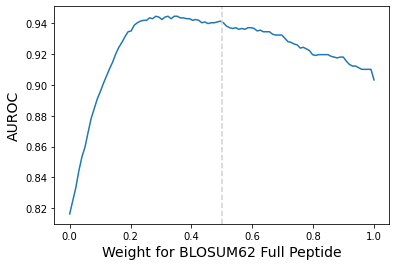

<Figure size 432x288 with 0 Axes>

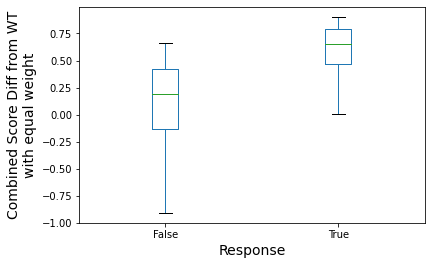

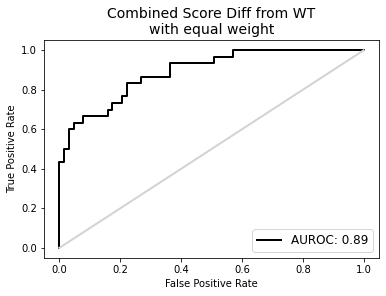

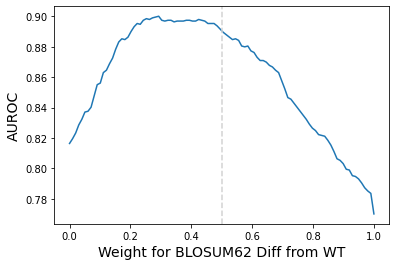

In [129]:
## now, try to make a combined plot

# rescale blosum and tcrdock_pae to be between 0 and 1
df['blosum_full_rescaled'] = (df['blosum_full'] - df['blosum_full'].min()) / (df['blosum_full'].max() - df['blosum_full'].min())
df['blosum_diff_rescaled'] = (df['blosum_diff'] - df['blosum_diff'].min()) / (df['blosum_diff'].max() - df['blosum_diff'].min())
df['tcrdock_pae_rescaled'] = (df['tcrdock_pae'] - df['tcrdock_pae'].min()) / (df['tcrdock_pae'].max() - df['tcrdock_pae'].min())

# add them up (remember that pae needs to be negatied if we want to keep everything as "higher is better")
df['combined_score_full'] = df['blosum_full_rescaled'] - df['tcrdock_pae_rescaled']
df['combined_score_diff'] = df['blosum_diff_rescaled'] - df['tcrdock_pae_rescaled']

# boxplot
plt.figure(figsize=(6, 4))
df.boxplot(column='combined_score_full', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('Combined Score Full Peptide\nwith equal weight', fontsize=14)
plt.show()

# roc curve plot and auroc for combined score
fpr, tpr, _ = roc_curve(df['Resp'], df['combined_score_full'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2,)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined Score Full Peptide\nwith equal weight', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

## AUROC gets better, so the rescaled combination is good!

# try auroc with different relative weights, plot auroc as a function of the weight
weights = np.linspace(0, 1, 100)
aurocs = []
for weight in weights:
    df['combined_score_full'] = weight * df['blosum_full_rescaled'] - (1 - weight) * df['tcrdock_pae_rescaled']
    fpr, tpr, _ = roc_curve(df['Resp'], df['combined_score_full'])
    roc_auc = auc(fpr, tpr)
    aurocs.append(roc_auc)

plt.figure(figsize=(6, 4))
plt.plot(weights, aurocs)
plt.axvline(0.5, color='lightgrey', linestyle='--')
plt.xlabel('Weight for BLOSUM62 Full Peptide', fontsize=14)
plt.ylabel('AUROC', fontsize=14)
plt.show()



# boxplot
plt.figure(figsize=(6, 4))
df.boxplot(column='combined_score_diff', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('Combined Score Diff from WT\nwith equal weight', fontsize=14)
plt.show()

# roc curve plot and auroc for combined score
fpr, tpr, _ = roc_curve(df['Resp'], df['combined_score_diff'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined Score Diff from WT\nwith equal weight', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

## AUROC gets better, so the rescaled combination is good!

# try auroc with different relative weights, plot auroc as a function of the weight
weights = np.linspace(0, 1, 100)
aurocs = []
for weight in weights:
    df['combined_score_diff'] = weight * df['blosum_diff_rescaled'] - (1 - weight) * df['tcrdock_pae_rescaled']
    fpr, tpr, _ = roc_curve(df['Resp'], df['combined_score_diff'])
    roc_auc = auc(fpr, tpr)
    aurocs.append(roc_auc)

plt.figure(figsize=(6, 4))
plt.plot(weights, aurocs)
plt.axvline(0.5, color='lightgrey', linestyle='--')
plt.xlabel('Weight for BLOSUM62 Diff from WT', fontsize=14)
plt.ylabel('AUROC', fontsize=14)
plt.show()


In [130]:
## now, find a way to sample peptides from BLOSUM matrix

# print(BLOSUM62)

# for aa in AMINO_ACIDS:
#     print(aa, np.array(BLOSUM62[aa].values()))

# print the marginal distribution of amino acids
marginal = np.array([np.array(BLOSUM62[aa].values()).sum() for aa in AMINO_ACIDS])

print(marginal)


[-23. -43. -26. -17. -36. -42. -22. -38. -21. -37. -22. -20. -41. -14.
 -27. -15. -20. -32. -45. -26.]


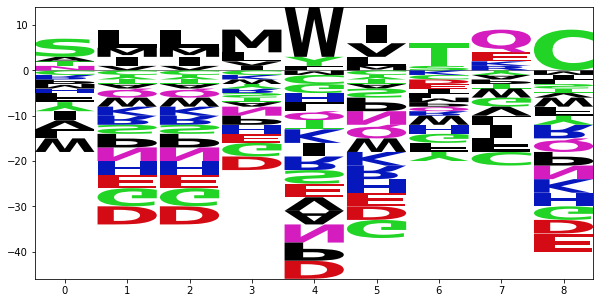

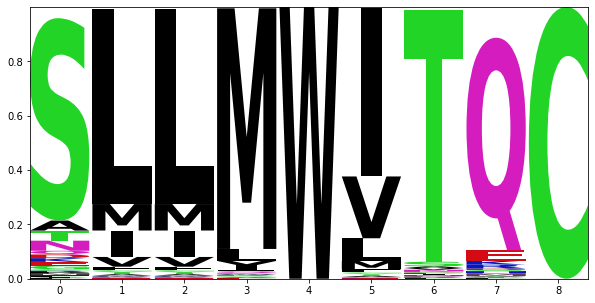

In [131]:
import logomaker

wt_seq_blosum62_logo = pd.DataFrame({i: {aa: BLOSUM62_DICT[WT_SEQ[i]][aa] for aa in AMINO_ACIDS} for i in range(len(WT_SEQ))}).T.astype(int)
logomaker.Logo(wt_seq_blosum62_logo, figsize=(10, 5), ax=None)
plt.show()

wt_seq_blosum62_logo = pd.DataFrame({i: {aa: SOFTMAX_BLOSUM62_DICT[WT_SEQ[i]][aa] for aa in AMINO_ACIDS} for i in range(len(WT_SEQ))}).T
logomaker.Logo(wt_seq_blosum62_logo, figsize=(10, 5), ax=None)
plt.show()

In [14]:
## get alphafold3 results, populate the dataframe with them

# ## unzip everything
# for filename in os.listdir('alphafold3'):
#     if filename.endswith('.zip'):
#         os.makedirs(f'alphafold3/{filename[:-4]}', exist_ok=True)
#         os.system(f'unzip alphafold3/{filename} -d alphafold3/{filename[:-4]}')
# os.system(f'mv alphafold3/fold_nyeso_wt_1 alphafold3/fold_nyeso_{WT_SEQ.lower()}_1')

df_orig

,name,sequence,Top,hamming_distance_from_wt,tcrdock_pae,model,group,position,Resp,GFP,R1,R2,R3,af3_tcr_pmhc_pae_score,af3_ranking_scores
0,NYESO_p1,RLAQWISQA,T,5.0,5.087110,so3_convnet_base_ensemble,NaN,1,True,21.60,8.819959,8.652531,8.261667,0.994973,0.95
1,NYESO_p2,GLGTWISQV,T,5.0,5.109005,so3_convnet_base_ensemble,NaN,2,True,12.20,3.057442,4.626006,2.113691,1.093910,0.94
2,NYESO_p3,SLLQWVSQV,T,4.0,5.109279,so3_convnet_base_ensemble_fixed_structure,NaN,3,True,73.80,27.669989,26.298373,24.121413,1.374538,0.92
3,NYESO_p4,GLGQWISQA,T,5.0,5.114267,so3_convnet_base_ensemble,NaN,4,False,0.50,0.011150,0.004608,0.003092,1.022366,0.95
4,NYESO_p5,SLLQWISQV,T,3.0,5.134573,so3_convnet_base_ensemble_fixed_structure,NaN,5,True,79.20,26.475036,24.544710,28.995010,1.033960,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NYESO_p92,ALLEWLTTL,F,5.0,6.097432,so3_convnet_noise=0p5_fixed_structure,sampled_between_5p5_and_7_pae,92,False,0.18,0.008657,0.017513,0.003251,11.111741,0.60
92,NYESO_p93,CLMTWLDVV,F,7.0,6.104698,so3_convnet_noise=0p5_fixed_structure,sampled_between_5p5_and_7_pae,93,False,0.22,0.000000,0.000000,0.008956,1.560459,0.88
93,unstim,NaN,F,NaN,NaN,NaN,NaN,94,False,0.20,0.007500,0.008697,0.002912,NaN,NaN
94,NYESO_p95_wt,SLLMWITQC,F,0.0,NaN,NaN,NaN,95,True,64.90,13.907838,16.127363,15.616423,1.045415,0.95


In [20]:
## compute the AF3 PAE score by summing up `chain_pair_pae_min` values corresponding to the interaction between the peptide and the MHC, the peptide and both tcr chains, the MHC and both tcr chains
## also put column with ranking score to see how those correlate, as a baseline
## take the best-ranked structure out of the 5 that get returned

def get_ranking_score(json_dict):
    return json_dict['ranking_score']

def get_tcr_pmhc_pae_score(json_dict):
    return json_dict['chain_pair_pae_min'][0][1] \
            + json_dict['chain_pair_pae_min'][0][2] \
            + json_dict['chain_pair_pae_min'][0][3] \
            + json_dict['chain_pair_pae_min'][1][0] \
            + json_dict['chain_pair_pae_min'][1][2] \
            + json_dict['chain_pair_pae_min'][1][3] \
            + json_dict['chain_pair_pae_min'][2][0] \
            + json_dict['chain_pair_pae_min'][2][1] \
            + json_dict['chain_pair_pae_min'][3][0] \
            + json_dict['chain_pair_pae_min'][3][1]


import json

af3_tcr_pmhc_pae_scores = []
af3_ranking_scores = []
for sequence in df_orig['sequence']:
    if type(sequence) == str:
        if os.path.exists(f'alphafold3/fold_nyeso_{sequence.lower()}_1/'):
            temp_ranking_scores = []
            temp_pae_scores = []
            for i in range(5):
                with open(f'alphafold3/fold_nyeso_{sequence.lower()}_1/fold_nyeso_{sequence.lower()}_1_summary_confidences_{i}.json') as f:
                    summary_confidences = json.load(f)
                temp_ranking_scores.append(get_ranking_score(summary_confidences))
                temp_pae_scores.append(get_tcr_pmhc_pae_score(summary_confidences))
            
            # select best based on ranking score
            best_i = np.argmax(temp_ranking_scores)
            af3_tcr_pmhc_pae_scores.append(temp_pae_scores[best_i])
            af3_ranking_scores.append(temp_ranking_scores[best_i])
        else:
            af3_tcr_pmhc_pae_scores.append(np.nan)
            af3_ranking_scores.append(np.nan)
    else:
        af3_tcr_pmhc_pae_scores.append(np.nan)
        af3_ranking_scores.append(np.nan)

df_orig['af3_tcr_pmhc_pae_score'] = af3_tcr_pmhc_pae_scores
df_orig['af3_ranking_scores'] = af3_ranking_scores


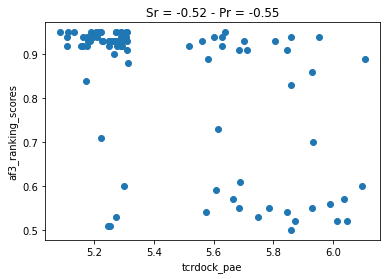

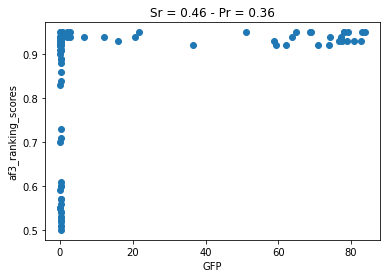

In [21]:
metric = 'af3_ranking_scores'

mask = ~np.isnan(df_orig['tcrdock_pae']) & ~np.isnan(df_orig[metric])
sr, sr_pval = spearmanr(df_orig['tcrdock_pae'][mask], df_orig[metric][mask])
pr, pr_pval = pearsonr(df_orig['tcrdock_pae'][mask], df_orig[metric][mask])
plt.plot(df_orig['tcrdock_pae'], df_orig[metric], 'o')
plt.title(f'Sr = {sr:.2f} - Pr = {pr:.2f}')
plt.xlabel('tcrdock_pae')
plt.ylabel(metric)
plt.show()


mask = ~np.isnan(df_orig['GFP']) & ~np.isnan(df_orig[metric])
sr, sr_pval = spearmanr(df_orig['GFP'][mask], df_orig[metric][mask])
pr, pr_pval = pearsonr(df_orig['GFP'][mask], df_orig[metric][mask])
plt.plot(df_orig['GFP'], df_orig[metric], 'o')
plt.title(f'Sr = {sr:.2f} - Pr = {pr:.2f}')
plt.xlabel('GFP')
plt.ylabel(metric)
plt.show()



In [22]:
## is_self analysis

from tqdm import tqdm
from Bio import SeqIO

PATH_TO_FASTA_OF_SELF_PROTEINOME = '../UP000005640_9606.fasta'

fasta_sequences = SeqIO.parse(open(PATH_TO_FASTA_OF_SELF_PROTEINOME), 'fasta')

def is_in_self_brute_force(peptide, fasta_sequences):
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        if peptide in sequence:
            print(name)
            return 1, name
    return 0, None

is_self_peptide, self_protein_name = [], []
for peptide in tqdm(df['sequence']):
    is_self, name = is_in_self_brute_force(peptide, fasta_sequences)
    is_self_peptide.append(is_self)
    self_protein_name.append(name)

df['is_self_peptide'] = is_self_peptide
df['self_protein_name'] = self_protein_name

print(df['is_self_peptide'].sum())


100%|██████████| 93/93 [00:00<00:00, 594.78it/s]

0
